In [2]:
import numpy as np 
import scipy 
from scipy.stats import norm
from scipy.stats import skewnorm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.pyplot import cm
import os
import random
from tqdm import tqdm
import numba as nb
from numba import njit
from numba import jit
import matplotlib.animation as animation
from textwrap import wrap
import data_visualization as dv


#   1. P1 can win if P2 decides 200ms or more before TRIAL_TIME and P2 decides 200ms after P1
#      - this simulates using sensory information to make a decision
#   2. Either player randomly wins if the difference between the decision times 
#      is less than 200ms  
#   3. Both players still lose if decision time >1500

In [3]:

#%%
PATH = 'C:\\Users\\Seth Sullivan\\OneDrive - University of Delaware - o365\\Desktop\\Modeling\\Optimal_Decision_Time_Asymmetric_Figures\\'
DELAY = 275
MOVEMENT_TIME = 100
TRIAL_TIME = 1500
wheel = dv.ColorWheel()
#%% Update parameters function
def update_params(label_color):
    params = {"ytick.color" : label_color,
              "xtick.color" : label_color,
              "axes.labelcolor" : label_color,
              "axes.edgecolor" : label_color,
              "axes.titlecolor": label_color, 
              'legend.labelcolor': label_color,
              }
    plt.rcParams.update(params)

In [4]:
#%% Heat Map Function
# p1_wins1 rows are the p1_decision times and columns are p2_decision times
# Since P1 wins are the rows, then need to make them columns so it fits with
# having P1 decision times on the x-axis and P2 decision times at y-axis
# Remember that the bottom left is 0,0 bc--> origin = lower
# REMEMBER TO TRANSPOSE ANYTHING NEW***!!*!*!*!*!*!*!*!

def heatmap(p1_wins,p2_wins, decision_means_p1, decision_means_p2, 
            p1_reach_times, p2_reach_times, p1_indecision, p2_indecision, 
            p1_perc_both_decided_wins, p2_perc_both_decided_wins, SD1, SD2,
            absolute = True, indecisions = False, both_decide = False, abs_minus_both_decided = False, 
            abs_minus_ind=False, abs_plus_both_decided=False, save = False, both_decided_minus_ind = False):
    #Have to transpose to get the axes right
    
    p1_wins = p1_wins.T
    p2_wins = p2_wins.T
    p1_indecision = p1_indecision.T
    p2_indecision = p2_indecision.T
    p1_perc_both_decided_wins = p1_perc_both_decided_wins.T
    p2_perc_both_decided_wins = p2_perc_both_decided_wins.T
    # Calculate percents
    p1_perc_wins = (p1_wins/NUM_TRIALS)*100
    p2_perc_wins = (p2_wins/NUM_TRIALS)*100
    p1_perc_indecision = (p1_indecision/NUM_TRIALS)*100
    p2_perc_indecision = (p2_indecision/NUM_TRIALS)*100
    # Find average of actual decision times
    p1_avg_dt = np.zeros((len(decision_means_p1), len(decision_means_p2)))
    p1_avg_dt_final = np.zeros(len(decision_means_p1))
    for i in range(len(decision_means_p1)):
        for j in range(len(decision_means_p2)):
            p1_avg_dt[i,j] = np.mean(p1_reach_time[i,j,:])
    for i in range(len(decision_means_p1)):
        p1_avg_dt_final[i] = np.mean(p1_avg_dt[i,:])       
    # Create array for specific instance -------------------------------------
    if absolute:
        X = np.array([p1_perc_wins,p2_perc_wins])
    if both_decide:
        X = np.array([p1_perc_both_decided_wins, p2_perc_both_decided_wins])
    if indecisions:
        X = np.array([p1_perc_indecision, p2_perc_indecision])
    if abs_minus_both_decided:
        p1_abs_minus_both_decided = p1_perc_wins - p1_perc_both_decided_wins
        p2_abs_minus_both_decided = p2_perc_wins - p2_perc_both_decided_wins
        X = [p1_abs_minus_both_decided,p2_abs_minus_both_decided]
    if abs_minus_ind:
        p1_wins_minus_indecisions = p1_perc_wins - p1_perc_indecision
        p2_wins_minus_indecisions = p1_perc_wins - p1_perc_indecision
        X = np.array([p1_wins_minus_indecisions, p2_wins_minus_indecisions])
    if both_decided_minus_ind:
        X = [p1_perc_both_decided_wins - p1_perc_indecision, p2_perc_both_decided_wins - p2_perc_indecision]
    if abs_plus_both_decided:
        p1_abs_plus_both_decided = p1_perc_wins + p1_perc_both_decided_wins
        p2_abs_plus_both_decided = p2_perc_wins + p2_perc_both_decided_wins
        X = [p1_abs_plus_both_decided,p2_abs_plus_both_decided]
    X_locations = np.arange(len(p1_reach_times))
    Y_locations = np.arange(len(p2_reach_times))
    # Create x-tick labels including normal distribution mean and (decision time mean)
    xticklabs = []
    c=0
    for dt in p1_avg_dt_final:
        xticklabs.append(f'{decision_means_p1[c]}')#'\n({dt:.0f})')
        c=c+1
    title_label = ['Player 1', 'Player 2']
    save_title_label = ['Asymmetric_Player1_NoFeedback', 'Asymmetric_Player2']
    c=0
    weights = {'axis_weight': 550, 'title_weight': 600}
    #print(X[0,:,:])
    for player in X:
        if c == 1:
            break
        # print('SPACE')
        
        # Set labels and titles default to white
        if save:
            update_params('w')
            title_color = 'w'
        else:
            update_params('black')
            title_color = 'black'
        fig, ax = plt.subplots(dpi = 200)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='4%', pad=0.05)
        if absolute or both_decide or indecisions:
            vmin = 0
            vmax = 100
        else: 
            vmin = 100
            vmax = -100
        im = ax.imshow(player, cmap = cm.viridis, origin = 'lower', vmin= vmin, vmax=vmax) #vmin ensures that lowest color is at bottom and vmax ensures brightest color is at top no matter what the max of the data is
        cbar = fig.colorbar(im, cax=cax, orientation='vertical')
        
        ax.set_xticks(X_locations) # Usually need to set the tick locations before the labels 
        ax.set_yticks(Y_locations)
        ax.set_xticklabels(xticklabs, fontsize = 'x-small', rotation = 45)
        ax.set_yticklabels(decision_means_p2, fontsize = 'x-small')
        # Select which xtick labels to pick
        n = 3  # Keeps every 4th label
        [l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]   
        [l.set_visible(False) for (i,l) in enumerate(ax.yaxis.get_ticklabels()) if i % n != 0] 
        # Create second axis for true decision times
        secax = ax.secondary_xaxis('top', functions = (lambda x: x, lambda x: x))
        secax.set_xticks(X_locations)
        secax.set_xticklabels(p1_avg_dt_final.astype(int), size = 'xx-small', rotation = 45)
        secax.set_xlabel('True Decision Time', fontweight = weights['axis_weight'])
        
        # ax2 = ax.twiny()
        # ax2.set_xticks(X_locations)
        # ax2.set_xticklabels(p1_avg_dt_final.astype(int), fontsize = 'xx-large', rotation = 45)
        # ax2.xaxis.set_ticks_position('top') # set the position of the second x-axis to bottom
        # ax2.xaxis.set_label_position('top') # set the position of the second x-axis to bottom
        # ax2.spines['top'].set_position(('outward', 0))
        # ax2.set_xlabel('True Mean Decision Time')
        
        if absolute:
            ax.set_title(f'{title_label[c]} Absolute Wins', fontweight = weights['title_weight'], c = title_color)
            cbar.set_label('Wins (%)', rotation = 270, labelpad = 9.5, fontweight = weights['axis_weight'], c = title_color)
            cbar.set_ticks([20,40,60,80,100])
            cbar.set_ticklabels([20,40,60,80,100])
            cbar.ax.set_ylim(0,100)
            save_name = 'Absolute_Wins'
            txt = 'PLayer 1 absolute wins for each decision time, against each decision time of Player 2.\
                The white crosses indicate the maximum for each row. The decision times are the mean times\
                    used for the normal distribution with SD = 100.'
        if both_decide:
            ax.set_title(f'{title_label[c]} Both Decided Wins', fontweight = weights['title_weight'], c = title_color)
            cbar.set_label('Wins (%)', rotation = 270, labelpad = 9.5, fontweight = weights['axis_weight'], c = title_color)
            cbar.ax.set_ylim(0,100)
            save_name = 'Both_Decided_Wins'
            txt = 'PLayer 1 relative wins for each decision time, against each decision time of Player 2.\
                The white crosses indicate the maximum for each row. The decision times are the mean times\
                    used for the normal distribution with SD = 100.'
        if abs_minus_both_decided:
            ax.set_title(f'{title_label[c]} Absolute - Both Decided Wins', fontweight = weights['title_weight'], c = title_color)
            cbar.set_label('Win Difference (%)', rotation = 270, labelpad = 9.5, fontweight = weights['axis_weight'], c = title_color)
            cbar.ax.set_ylim(-100,100)
      
            save_name = 'Absolute_minus_both_decided'
        if abs_minus_ind:
            ax.set_title(f'{title_label[c]} Absolute Wins - Indecisions', fontweight = weights['title_weight'], c = title_color)
            cbar.set_label('Difference (%)', rotation = 270, labelpad = 9.5, fontweight = weights['axis_weight'], c = title_color)
            cbar.ax.set_ylim(-100,100)
            # cbar.set_ticks([20,40,60,80,100])
            # cbar.set_ticklabels([20,40,60,80,100])
            save_name = 'Absolute_minus_Indecisions'
        if both_decided_minus_ind:
            ax.set_title(f'{title_label[c]} Both Decided Wins - Indecisions', fontweight = weights['title_weight'], c = title_color)
            cbar.set_label('Difference (%)', rotation = 270, labelpad = 9.5, fontweight = weights['axis_weight'], c = title_color)
            cbar.ax.set_ylim(-100,100)
            save_name = 'Both_decided_wins_minus_indecisions'
        if indecisions:
            ax.set_title(f'{title_label[c]} Indecisions', fontweight = weights['title_weight'], c = title_color)
            cbar.set_label('Indecisions (%)', rotation = 270, labelpad = 9.5, fontweight = weights['axis_weight'], c = title_color)
            cbar.ax.set_ylim(0,100)
            save_name = 'Indecisions'
        if abs_plus_both_decided:
            ax.set_title(f'{title_label[c]} Absolute Wins + Both Decide Wins', fontweight = weights['title_weight'], c = title_color)
            cbar.set_label('Wins (%)', rotation = 270, labelpad = 9.5, fontweight = weights['axis_weight'], c = title_color)
            save_name = 'Absolute_wins_plus_both_decided'
        ax.set_xlabel('Player 1 Mean Decision Time', fontweight = weights['axis_weight'])
        ax.set_ylabel('Player 2 Mean Decision Time', fontweight = weights['axis_weight'])
        # USE IF YOU WANT NUMBERS ON EACH BOX
        # for i in range(len(p2_wins)):
        #     for j in range(len(p2_wins)):
               
                # text = ax.text(j, i, f'{player[i,j]:.2f}',
                #             ha="center", va="center", color="w", 
                #             fontweight='medium', size = 'x-small')
        # Place a + on the maximum wins for each row
        for i in range(len(player)):
            if np.all(player == X[1]):
                k = np.argwhere(player[:,i] == np.amax(player[:,i])) #in case of duplicates
                for j in k: 
                    text = ax.text(i, np.argmax(player[:,i]),'+', 
                                   ha="center", va="center", color="w", 
                                   fontweight='medium', size = 'x-small')
            if np.all(player == X[0]):   
                k = np.argwhere(player[i,:] == np.amax(player[i,:])) #in case of duplicates
                for j in k: 
                    text = ax.text(np.argmax(player[i,:]), i, '+',
                                   ha="center", va="center", color="w", 
                                   fontweight='medium', size = 'x-small')
                   
                    
        # Trying to plot something where P1 actually made a decision
        # for i in p1_avg_dt_final:
        #     for j in decision_means_p2:
        #         text = ax.text(i, j,'o', 
        #                            ha="center", va="center", color="r", 
        #                            fontweight='medium', size = 'x-small')
        # print(len(X[0]))
        # x = np.zeros(len(X[0]))
        # x1 = np.zeros(len(X[0]))
        # y = np.zeros(len(X[1]))
        # for i in range(len(p1_wins)):
        #     x[i] = np.argmax(p1_wins[i,:]) #want the location, not the win number
        #     x1[i] = p1_reach_times[int(x[i])] # now place that location into the decision times to get the decision time maximum and then put that into an array to plot
        # ax.scatter(x1,p2_reach_times)    
        if save:
            plt.savefig(PATH+f'{save_title_label[c]}_{save_name}_SD1_{SD1}_SD2_{SD2}',
                    dpi=600, bbox_inches = 'tight',transparent=True)    
        c=c+1 
    #plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=6)
    plt.tight_layout()
    plt.show()

In [5]:
#%% Simulation Function Only P1 Sensory Feedback
@njit 
def Simulate_Wins_Only_P1_Sensory_Feedback(TRIAL_TIME,NUM_TRIALS, decision_means_p1, decision_means_p2,
                  p1_reach_time, p2_reach_time):
    # Initialize what I want to return
    p1_wins = np.zeros((len(decision_means_p1), len(decision_means_p2)))
    p2_wins = np.zeros((len(decision_means_p1), len(decision_means_p2)))
    p1_indecision = np.zeros((len(decision_means_p1), len(decision_means_p2)))
    p2_indecision = np.zeros((len(decision_means_p1), len(decision_means_p2)))
    neither_decision = np.zeros((len(decision_means_p1), len(decision_means_p2)))
    p1_decision_array = np.empty((len(decision_means_p1), len(decision_means_p2), NUM_TRIALS)) #0 is indecision, 1 is win, -1 is loss
    p2_decision_array = np.empty((len(decision_means_p1), len(decision_means_p2), NUM_TRIALS))
    p1_both_decided_array = np.empty((len(decision_means_p1), len(decision_means_p2), NUM_TRIALS)) #0 is indecision, 1 is win, -1 is loss
    p2_both_decided_array = np.empty((len(decision_means_p1), len(decision_means_p2), NUM_TRIALS))
    c = -1 #decision time iterator
    # Simulation -------------------------------------------------------------
    for dt_p1 in (decision_means_p1):
        c=c+1
        z=-1
        for dt_p2 in decision_means_p2:
            z=z+1
            for i in range(NUM_TRIALS): # can probably speed this up by doing the norm.rvs for the number of trials instead of running through a for loop, but not sure how to do the if statements then 
                
                #print(p1_reach_time[c,z,i],p2_reach_time[c,z,i])
                
                # Using sensory evidence ------------------------------------------
                # if player 1 is deciding after player 2 and player 2 has decided 
                # at least 200ms before 1500, then 1 can immediately win 
                
                if ((p1_reach_time[c,z,i] - p2_reach_time[c,z,i] >= DELAY) and (p1_reach_time[c,z,i] < TRIAL_TIME) and (p2_reach_time[c,z,i] < TRIAL_TIME)):
                    p1_wins[c,z] += 1
                    p1_reach_time[c,z,i] = p2_reach_time[c,z,i] + DELAY # change decision time to 200ms after opponent
                    p1_decision_array[c,z,i] = 1
                    p2_decision_array[c,z,i] = -1
                    p1_both_decided_array[c,z,i] = 1
                    p2_both_decided_array[c,z,i] = -1
                    # Know that p2 didn't make an indecision because 1500-p2_dt >= 200 
                
                # if (p2_reach_time[c,z,i] >= p1_reach_time[c,z,i] + DELAY and 
                #       TRIAL_TIME - p1_reach_time[c,z,i] >= DELAY):
                #     p2_wins[c,z] += 1
                #     p2_reach_time[c,z,i] = p1_reach_time[c,z,i] + DELAY # change decision time to 200ms after opponent
                #     p1_decision_array[c,z,i] = -1
                #     p2_decision_array[c,z,i] = 1
                #     p1_both_decided_array[c,z,i] = -1
                #     p2_both_decided_array[c,z,i] = 1
                #-----------------------------------------------------------------
                # ------ No sensory evidence could be used------------------------
                
                # Both made it, random winner
                elif (p1_reach_time[c,z,i]<TRIAL_TIME and
                      p2_reach_time[c,z,i]<TRIAL_TIME):
                    rand = random.random()
                    if rand>=0.5:
                        p1_wins[c,z] += 1
                        p1_decision_array[c,z,i] = 1
                        p2_decision_array[c,z,i] = -1
                        p1_both_decided_array[c,z,i] = 1
                        p2_both_decided_array[c,z,i] = -1
                    else:
                        p2_wins[c,z] += 1    
                        p1_decision_array[c,z,i] = -1
                        p2_decision_array[c,z,i] = 1     
                        p1_both_decided_array[c,z,i] = -1
                        p2_both_decided_array[c,z,i] = 1                                                                                      
                # P1 didn't make it
                elif (p1_reach_time[c,z,i]>= TRIAL_TIME and
                      p2_reach_time[c,z,i]<TRIAL_TIME):
                    p2_wins[c,z] += 1
                    p1_indecision[c,z] += 1
                    p1_decision_array[c,z,i] = 0
                    p2_decision_array[c,z,i] = 1
                    p1_both_decided_array[c,z,i] = 0
                    p2_both_decided_array[c,z,i] = 1
                # P2 didn't make it
                elif (p1_reach_time[c,z,i]<TRIAL_TIME and 
                      p2_reach_time[c,z,i]>=TRIAL_TIME):
                    p1_wins[c,z] += 1
                    p2_indecision[c,z] += 1
                    p1_decision_array[c,z,i] = 1
                    p2_decision_array[c,z,i] = 0
                    p1_both_decided_array[c,z,i] = 1
                    p2_both_decided_array[c,z,i] = 0
                # Both didn't make it 
                elif (p1_reach_time[c,z,i]>=TRIAL_TIME and 
                      p2_reach_time[c,z,i]>=TRIAL_TIME):
                    p1_indecision[c,z] += 1
                    p2_indecision[c,z] += 1
                    neither_decision[c,z] += 1
                    p1_decision_array[c,z,i] = 0
                    p2_decision_array[c,z,i] = 0
                    p1_both_decided_array[c,z,i] = 0
                    p2_both_decided_array[c,z,i] = 0
                else:
                    print("ERROR NO IF STATEMENT TRIGGERED")     
    return p1_wins, p2_wins, p1_indecision, p2_indecision, p1_reach_time, p2_reach_time, \
        p1_decision_array, p2_decision_array, p1_both_decided_array, p2_both_decided_array         

In [6]:
#%% Calculate both decided wins
@njit
def calc_both_decide_wins(NUM_TRIALS, decision_means_p1,decision_means_p2,
                          p1_decision_array,
                          p2_decision_array, 
                          p1_both_decided_array, 
                          p2_both_decided_array):
    p1_both_decided_wins = np.zeros((len(decision_means_p1), len(decision_means_p2)))
    p2_both_decided_wins = np.zeros((len(decision_means_p1), len(decision_means_p2)))
    p1_perc_both_decided_wins = np.zeros((len(decision_means_p1), len(decision_means_p2)))
    p2_perc_both_decided_wins = np.zeros((len(decision_means_p1), len(decision_means_p2)))
       
    # p1_both_decided_array = p1_decision_array #decision array
    # p2_both_decided_array = p2_decision_array     
    p1_indecision_index = np.argwhere(p1_decision_array == 0)
    p2_indecision_index = np.argwhere(p2_decision_array == 0)
      # Create arrays for when both decide 
      #Replace all 0's (indecisions) with nans
    for i in range(len(p1_indecision_index)):
        p1_both_decided_array[p1_indecision_index[i,0],p1_indecision_index[i,1],p1_indecision_index[i,2]] = np.nan
        p2_both_decided_array[p1_indecision_index[i,0],p1_indecision_index[i,1],p1_indecision_index[i,2]] = np.nan
    for i in range(len(p2_indecision_index)):
       p1_both_decided_array[p2_indecision_index[i,0],p2_indecision_index[i,1],p2_indecision_index[i,2]] = np.nan
       p2_both_decided_array[p2_indecision_index[i,0],p2_indecision_index[i,1],p2_indecision_index[i,2]] = np.nan
    # Count wins for each when both decide
    for i in range(len(decision_means_p1)):
        for j in range(len(decision_means_p2)):
            for k in range(NUM_TRIALS):
                if p1_both_decided_array[i,j,k]==1:
                    p1_both_decided_wins[i,j] += 1
                    # if np.isnan(p1_both_decided_array[i]):
                    #     print('error')
                    #print(f"Right wins on correct choice: {decision_array_R[i,j,k]}, {decision_array_L[i,j,k]}")
                # Prey won for correct choice
                elif p2_both_decided_array[i,j,k]==1:
                    p2_both_decided_wins[i,j] += 1
            if p1_both_decided_wins[i,j] == 0:
                p1_perc_both_decided_wins[i,j] = 0
            if p2_both_decided_wins[i,j] == 0:
                p2_perc_both_decided_wins[i,j] = 0
            if p1_both_decided_wins[i,j] != 0 and p2_both_decided_wins[i,j] != 0: 
                p1_perc_both_decided_wins[i,j] = (p1_both_decided_wins[i,j] / np.count_nonzero(~np.isnan(p1_both_decided_array[i,j,:])))*100
                p2_perc_both_decided_wins[i,j] = (p2_both_decided_wins[i,j] / np.count_nonzero(~np.isnan(p2_both_decided_array[i,j,:])))*100
        
    return p1_perc_both_decided_wins, p2_perc_both_decided_wins



In [7]:
#%% Constant Variables
TRIAL_TIME = 1500
NUM_TRIALS = 500000
#Start and end decision time for player 1
interval = 25
start_time1 = 1000
end_time1 = 1650
total_times1 = int((end_time1 - start_time1) / interval)+1
decision_means_p1 = np.zeros(total_times1)
# Start and end decision time for player 2
start_time = 1000
end_time = 1650
total_times2 = int((end_time - start_time) / interval)+1
decision_means_p2 = np.zeros(total_times2)
# Creating AVERAGE decision time arrays
# To be used in the norm.rvs
for i in range(total_times1):
    decision_means_p1[i] = start_time1
    start_time1 = start_time1 + interval
for i in range(total_times2):
    decision_means_p2[i] = start_time
    start_time = start_time + interval
decision_means_p1 = decision_means_p1.astype(int)
decision_means_p2 = decision_means_p2.astype(int)
#Decision time storage arrays
p1_reach_time = np.zeros((len(decision_means_p1), len(decision_means_p2),NUM_TRIALS))
p2_reach_time = np.zeros((len(decision_means_p1), len(decision_means_p2),NUM_TRIALS))
p1_decision_array = np.zeros((len(decision_means_p1), len(decision_means_p2),NUM_TRIALS))
p2_decision_array = np.zeros((len(decision_means_p1), len(decision_means_p2),NUM_TRIALS))
p1_both_decided_array = np.zeros((len(decision_means_p1), len(decision_means_p2),NUM_TRIALS))
p2_both_decided_array = np.zeros((len(decision_means_p1), len(decision_means_p2),NUM_TRIALS))

#%% Run Simulation w/ SD = 100,100
p1_std = 100
p2_std = 100
c=-1
for dt_p1 in (decision_means_p1):
    c=c+1
    z=-1
    for dt_p2 in decision_means_p2:
        z=z+1
        # p1_reach_time[c,z,:] = skewnorm.rvs(-3, dt_p1, 100, size = NUM_TRIALS)
        # p2_reach_time[c,z,:] = skewnorm.rvs(-3, dt_p2, 100, size = NUM_TRIALS)
        p1_reach_time[c,z,:] = norm.rvs(dt_p1, p1_std, size = NUM_TRIALS)
        p2_reach_time[c,z,:] = norm.rvs(dt_p2, p2_std, size = NUM_TRIALS)
#p1_decision_time = p1_reach_time - DELAY - MOVEMENT_TIME


#make response time arrays
# for dt_p1 in tqdm(decision_means_p1):
#         c=c+1
#         z=-1
#         for dt_p2 in decision_means_p2:
#             z=z+1

#-----------------------------------------------------------------------------
p1_wins, p2_wins, p1_indecision, p2_indecision, \
    p1_reach_time, p2_reach_time, p1_decision_array, p2_decision_array, \
        p1_both_decided_array, p2_both_decided_array = Simulate_Wins_Only_P1_Sensory_Feedback(TRIAL_TIME, NUM_TRIALS, decision_means_p1,
                                                                                      decision_means_p2, p1_reach_time, 
                                                                                      p2_reach_time)
# Calculate both decided wins
p1_perc_both_decided_wins, p2_perc_both_decided_wins = \
    calc_both_decide_wins(NUM_TRIALS,decision_means_p1, decision_means_p2, 
                          p1_decision_array, p2_decision_array, 
                          p1_both_decided_array,
                          p2_both_decided_array)

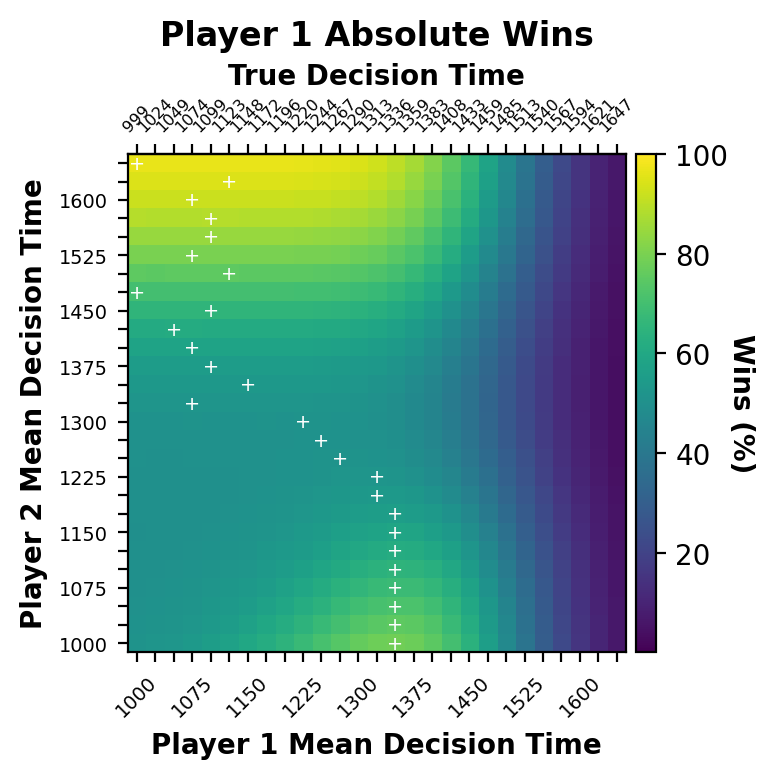

In [8]:
#%% Create heatmap
heatmap(p1_wins, p2_wins, decision_means_p1, decision_means_p2, 
            p1_reach_time, p2_reach_time, p1_indecision, p2_indecision, p1_perc_both_decided_wins,
            p2_perc_both_decided_wins, p1_std, p2_std,
            absolute=True,both_decide = False, indecisions = False, abs_minus_both_decided=False, abs_plus_both_decided=False,
            abs_minus_ind=False, both_decided_minus_ind = False, save=False)

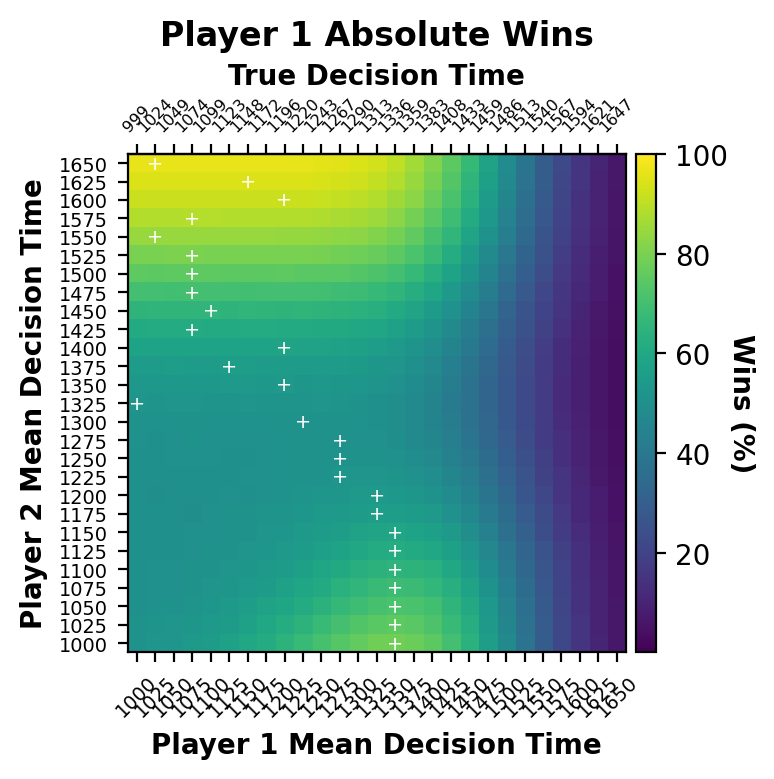

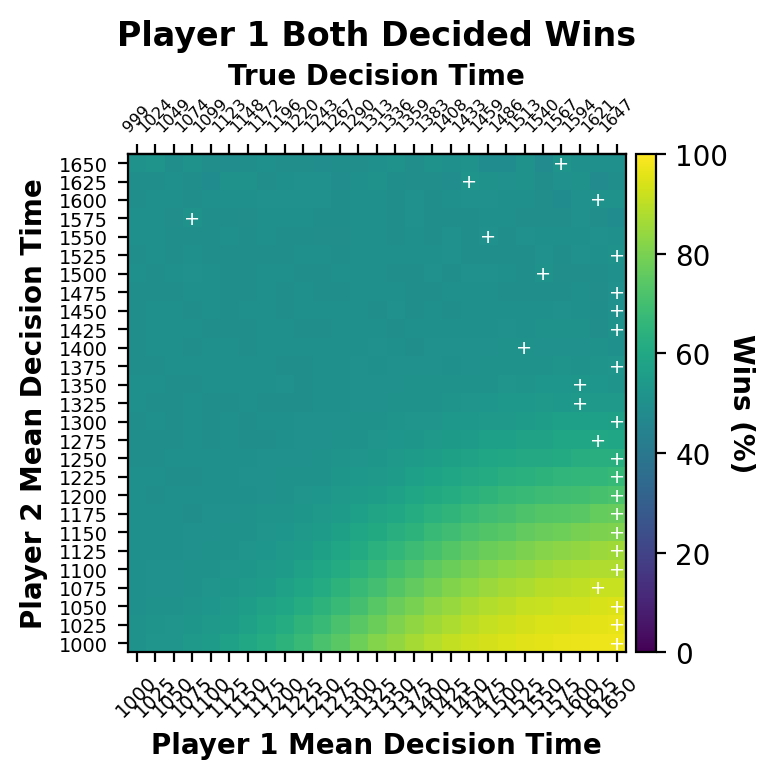

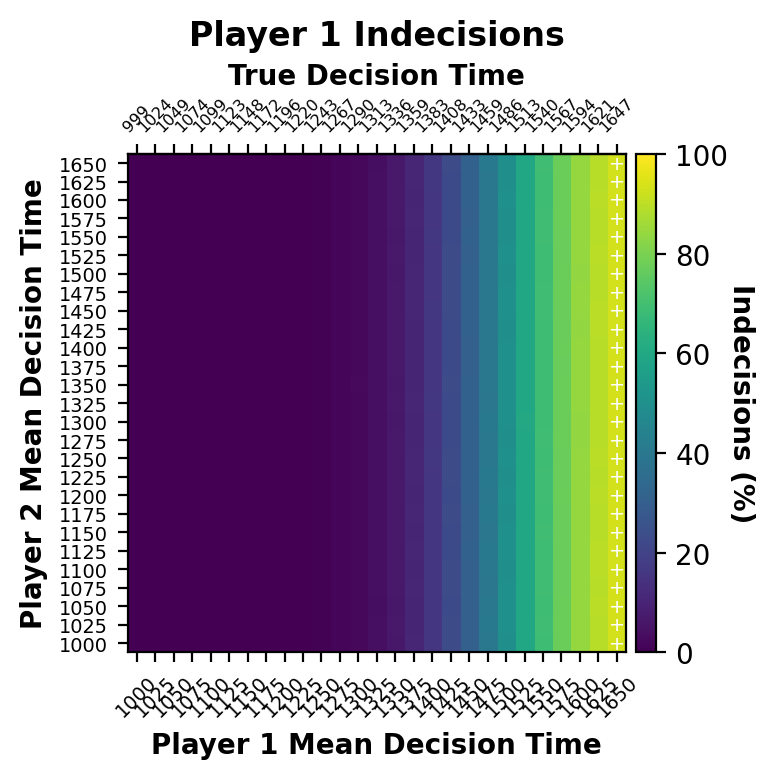

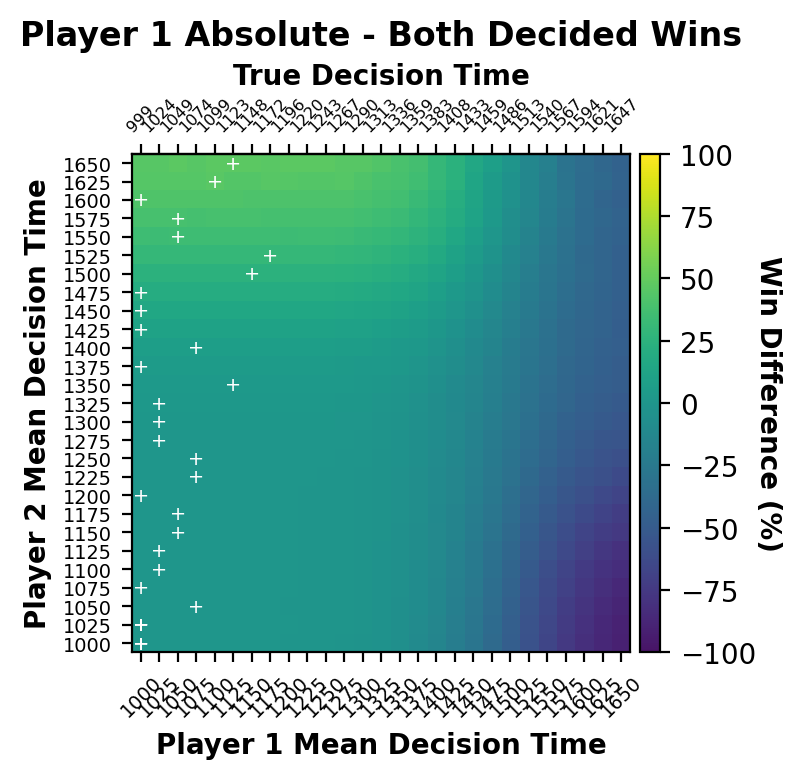

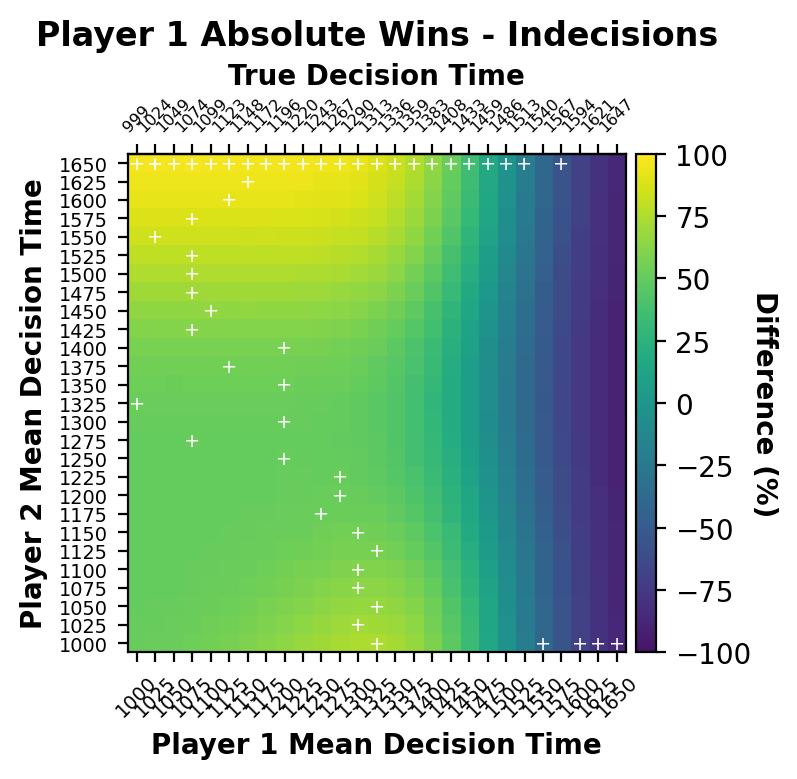

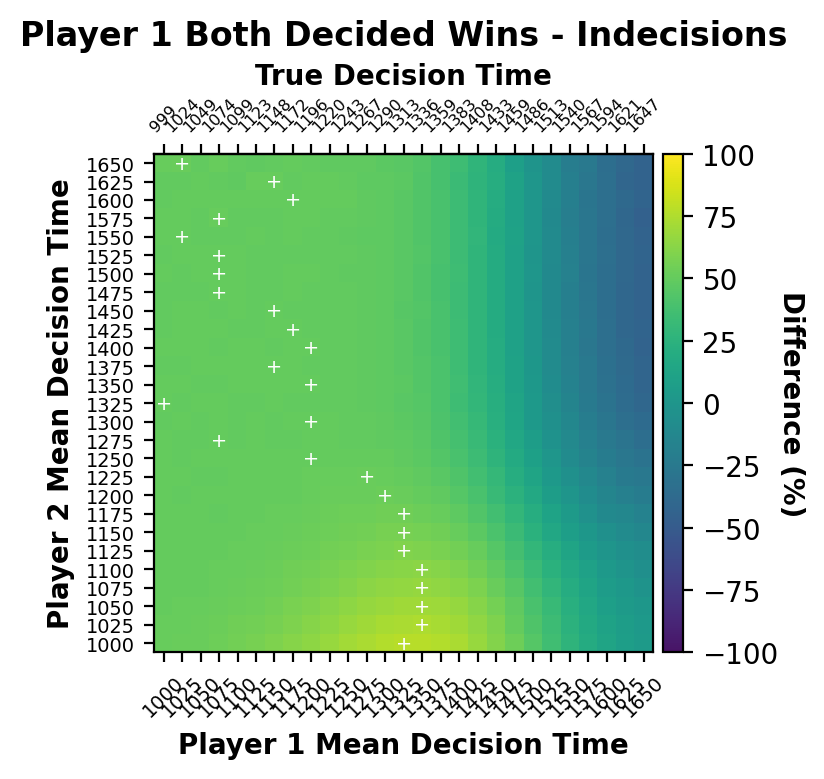

In [23]:
#%% Create heatmap loop to create all the figures
# x1,x2,x3,x4,x5,x6 = False,False,False,False,False,False
true_list = [False,False,False,False,False,False]
for i in range(len(true_list)):
    true_list[i] = True
    heatmap(p1_wins, p2_wins, decision_means_p1, decision_means_p2, 
            p1_reach_time, p2_reach_time, p1_indecision, p2_indecision, p1_perc_both_decided_wins,
            p2_perc_both_decided_wins, p1_std,p2_std,
            absolute=true_list[0],both_decide = true_list[1], indecisions = true_list[2], abs_minus_both_decided=true_list[3], abs_minus_ind=true_list[4], 
            both_decided_minus_ind = true_list[5], save=False)
    true_list[i] = False #set to false again 

In [44]:
p1_wins[4,-1]

96689.0

Find Optimals and plot like analytical

In [9]:
#%% Find optimal control policy 
# Find average of actual decision times
p1_avg_dt = np.zeros((len(decision_means_p1), len(decision_means_p2)))
p1_avg_dt_final = np.zeros(len(decision_means_p1))
for i in range(len(decision_means_p1)):
    for j in range(len(decision_means_p2)):
        p1_avg_dt[i,j] = np.mean(p1_reach_time[i,j,:])
for i in range(len(decision_means_p1)):
    p1_avg_dt_final[i] = np.mean(p1_avg_dt[i,:])  
    
optimal_mean = np.zeros(len(decision_means_p1))
optimal_indecisions = np.zeros(len(decision_means_p1))
optimal_wins = np.zeros(len(decision_means_p1))
for j in range(len(decision_means_p2)):
    max_win_index = np.argmax(p1_wins[:,j])
    optimal_mean[j] = p1_avg_dt_final[max_win_index]
    optimal_indecisions[j] = p1_indecision[max_win_index,j]
    optimal_wins[j] = p1_wins[max_win_index,j]
perc_optimal_wins = optimal_wins/NUM_TRIALS*100
perc_optimal_indecisions = optimal_indecisions/NUM_TRIALS*100

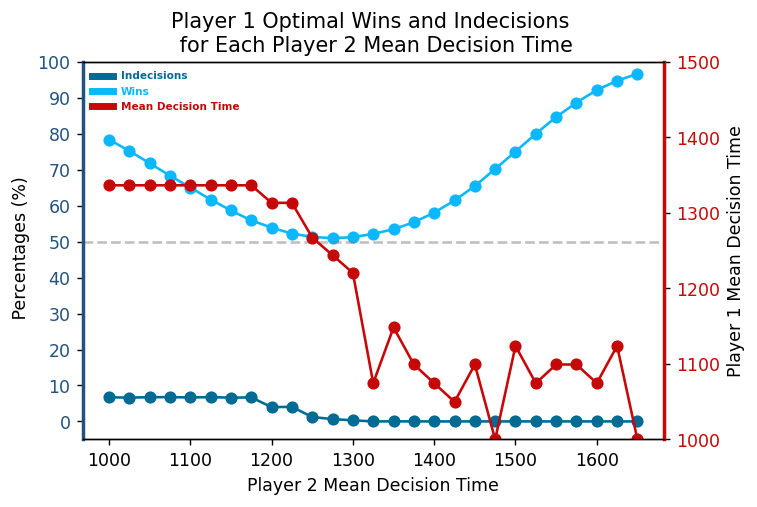

In [10]:
#%% All on one, with vertical lines on the selected mean decision time
plt.figure(dpi=125)
ax = plt.subplot()

ax.plot(decision_means_p2,perc_optimal_indecisions,'-o', c = wheel.dark_blue2, label = 'Indecisions')
ax.plot(decision_means_p2,perc_optimal_wins,'-o', c = wheel.light_blue, label = 'Wins')
ax.axhline(y=50, c = 'grey', linestyle = '--', alpha = 0.5)
# ax.axvline(x = 1000, ymin = 0, ymax = optimal_wins[0], color = 'black')
# ax.axvline(x = 1200, ymin = 0, ymax = optimal_wins[7], color = 'black',zorder = 0)
ax.set_ylim(-5,100)
ax.set_yticks(np.arange(0,110,10),np.arange(0,110,10),c = wheel.dark_blue)
ax.set_xlabel("Player 2 Mean Decision Time")
ax.set_ylabel(' Percentages (%)')
ax.spines['left'].set_color(wheel.dark_blue)
ax.spines['left'].set_linewidth(2)

ax2 = ax.twinx()
ax2.plot(decision_means_p2,optimal_mean,'-o', c=wheel.dark_red)
ax2.set_yticks(np.arange(1000,1600,100))
ax2.set_yticklabels(np.arange(1000,1600,100),c=wheel.dark_red)
ax2.set_ylim(1000,1500)
ax2.spines['right'].set_visible(True)
ax2.spines['right'].set_color(wheel.dark_red)
ax2.spines['right'].set_linewidth(2)
ax2.set_ylabel('Player 1 Mean Decision Time')
ax2.spines['left'].set_visible(False)
ax.set_title('Player 1 Optimal Wins and Indecisions \n for Each Player 2 Mean Decision Time')
labels = ['Indecisions', 'Wins','Mean Decision Time']
colors = [wheel.dark_blue2,wheel.light_blue,wheel.dark_red]
dv.Custom_Legend(ax, labels, colors)
plt.show()